In [ ]:
# Copyright [2024] [KTH Royal Institute of Technology] 
# Licensed under the Educational Community License, Version 2.0 (ECL-2.0)
# This file is part of the Computer Lab 1 for EL2805 - Reinforcement Learning.

import numpy as np
import matplotlib.pyplot as plt
import time
from IPython import display
import random

# Implemented methods
methods = ['DynProg', 'ValIter']

# Some colours
LIGHT_RED    = '#FFC4CC'
LIGHT_GREEN  = '#95FD99'
BLACK        = '#000000'
WHITE        = '#FFFFFF'
LIGHT_PURPLE = '#E8D0FF'

class Maze:

    # Actions
    STAY       = 0
    MOVE_LEFT  = 1
    MOVE_RIGHT = 2
    MOVE_UP    = 3
    MOVE_DOWN  = 4

    # Give names to actions
    actions_names = {
        STAY: "stay",
        MOVE_LEFT: "move left",
        MOVE_RIGHT: "move right",
        MOVE_UP: "move up",
        MOVE_DOWN: "move down"
    }

    # Reward values 
    STEP_REWARD = -100          #TODO
    GOAL_REWARD = 100          #TODO
    IMPOSSIBLE_REWARD = -100   #TODO
    MINOTAUR_REWARD = -100      #TODO

    def __init__(self, maze):
        """ Constructor of the environment Maze.
        """
        self.maze                     = maze
        self.actions                  = self.__actions()
        self.states, self.map         = self.__states()
        self.n_actions                = len(self.actions)
        self.n_states                 = len(self.states)
        self.transition_probabilities = self.__transitions()
        self.rewards                  = self.__rewards()

    def __actions(self):
        actions = dict()
        actions[self.STAY]       = (0, 0)
        actions[self.MOVE_LEFT]  = (0,-1)
        actions[self.MOVE_RIGHT] = (0, 1)
        actions[self.MOVE_UP]    = (-1,0)
        actions[self.MOVE_DOWN]  = (1,0)
        return actions

    def __states(self):
        
        states = dict()
        map = dict()
        s = 0
        for i in range(self.maze.shape[0]):
            for j in range(self.maze.shape[1]):
                for k in range(self.maze.shape[0]):
                    for l in range(self.maze.shape[1]):
                        if self.maze[i,j] != 1:
                            states[s] = ((i,j), (k,l))
                            map[((i,j), (k,l))] = s
                            s += 1
        
        states[s] = 'Eaten'
        map['Eaten'] = s
        s += 1
        
        states[s] = 'Win'
        map['Win'] = s
        
        return states, map

    def __move(self, state, action):               
        """ Makes a step in the maze, given a current position and an action. 
            If the action STAY or an inadmissible action is used, the player stays in place.
        
            :return list of tuples next_state: Possible states ((x,y), (x',y')) on the maze that the system can transition to.
        """

        if self.states[state] == 'Eaten' or self.states[state] == 'Win': # In these states, the game is over
            return [self.states[state]]
        
        else: # Compute the future possible positions given current (state, action)
            row_player = self.states[state][0][0] + self.actions[action][0] # Row of the player's next position 
            col_player = self.states[state][0][1] + self.actions[action][1] # Column of the player's next position 
            
            # Is the player getting out of the limits of the maze or hitting a wall?
            impossible_action_player = (row_player == -1 or row_player == self.maze.shape[0] or \
                                         col_player == -1 or col_player == self.maze.shape[1] or \
                                         self.maze[row_player, col_player] == 1 ) #TODO
            
            actions_minotaur = [[0, -1], [0, 1], [-1, 0], [1, 0]] # Possible moves for the Minotaur
            rows_minotaur, cols_minotaur = [], []
            for i in range(len(actions_minotaur)):
                # Is the minotaur getting out of the limits of the maze?
                impossible_action_minotaur = (self.states[state][1][0] + actions_minotaur[i][0] == -1) or \
                                             (self.states[state][1][0] + actions_minotaur[i][0] == self.maze.shape[0]) or \
                                             (self.states[state][1][1] + actions_minotaur[i][1] == -1) or \
                                             (self.states[state][1][1] + actions_minotaur[i][1] == self.maze.shape[1])
            
                if not impossible_action_minotaur:
                    rows_minotaur.append(self.states[state][1][0] + actions_minotaur[i][0])
                    cols_minotaur.append(self.states[state][1][1] + actions_minotaur[i][1])  
          

            # Based on the impossiblity check return the next possible states.
            if impossible_action_player: # The action is not possible, so the player remains in place
                states = []
                for i in range(len(rows_minotaur)):
                    
                    if (self.states[state][0][0] == rows_minotaur[i] and self.states[state][0][1] == cols_minotaur[i]): # TODO: We met the minotaur
                        states.append('Eaten')
                    
                    elif (self.maze[self.states[state][0][0], self.states[state][0][1]] == 2 ): # TODO: We are at the exit state, without meeting the minotaur
                        states.append('Win')
                
                    else: # The player remains in place, the minotaur moves randomly
                        states.append(((self.states[state][0][0], self.states[state][0][1]), (rows_minotaur[i], cols_minotaur[i])))
                
                return states
          
            else: # The action is possible, the player and the minotaur both move
                states = []
                for i in range(len(rows_minotaur)):
                
                    if (row_player == rows_minotaur[i] and col_player == cols_minotaur[i]): # TODO: We met the minotaur
                        states.append('Eaten')
                    
                    elif self.maze[row_player, col_player] == 2: # TODO:We are at the exit state, without meeting the minotaur
                        states.append('Win')
                    
                    else: # The player moves, the minotaur moves randomly
                        states.append(((row_player, col_player), (rows_minotaur[i], cols_minotaur[i])))
              
                return states
        
        
        

    def __transitions(self):
        """ Computes the transition probabilities for every state action pair.
            :return numpy.tensor transition probabilities: tensor of transition
            probabilities of dimension S*S*A
        """
        # Initialize the transition probailities tensor (S,S,A)
        dimensions = (self.n_states,self.n_states,self.n_actions)
        transition_probabilities = np.zeros(dimensions)

        # TODO: Compute the transition probabilities.
  
        for s in range(self.n_states):
                for a in range(self.n_actions):
                    next_possible_states = self.__move(s,a)
                    prob_next = 1.0/len(next_possible_states)

                    for t in next_possible_states:
                        transition_probabilities[self.map[t],s,a] = prob_next
    
        return transition_probabilities



    def __rewards(self):
        
        """ Computes the rewards for every state action pair """

        rewards = np.zeros((self.n_states, self.n_actions))
        
        for s in range(self.n_states):
            for a in range(self.n_actions):
                
                if self.states[s] == 'Eaten': # The player has been eaten
                    rewards[s, a] = self.MINOTAUR_REWARD
                
                elif self.states[s] == 'Win': # The player has won
                    rewards[s, a] = self.GOAL_REWARD
                
                else:                
                    next_states = self.__move(s,a)
                    next_s = next_states[0] # The reward does not depend on the next position of the minotaur, we just consider the first one
                    
                    if self.states[s][0] == next_s[0] and a != self.STAY: # The player hits a wall
                        rewards[s, a] = self.IMPOSSIBLE_REWARD
                    
                    else: # Regular move
                        rewards[s, a] = self.STEP_REWARD

        return rewards




    def simulate(self, start, policy, method):
        
        if method not in methods:
            error = 'ERROR: the argument method must be in {}'.format(methods)
            raise NameError(error)

        path = list()
        
        if method == 'DynProg':
            horizon = policy.shape[1] # Deduce the horizon from the policy shape
            t = 0 # Initialize current time
            s = self.map[start] # Initialize current state 
            path.append(start) # Add the starting position in the maze to the path
            
            while t < horizon - 1:
                a = int(policy[s, t]) # Move to next state given the policy and the current state       
                next_states = self.__move(s, a) # Move to next state given the policy and the current state
                map_next_states = [self.map[state] for state in next_states] # Map the next states
                next_s = np.random.choice(map_next_states, p=self.transition_probabilities[map_next_states, s, a])  # Choose the next state given the transition probabilities
                path.append(self.states[next_s]) # Add the next state to the path
                t +=1 # Update time and state for next iteration
                s = next_s
                
        if method == 'ValIter': 
            t = 1 # Initialize current state, next state and time
            s = self.map[start]
            path.append(start) # Add the starting position in the maze to the path
            next_states = self.__move(s, policy[s]) # Move to next state given the policy and the current state
            map_next_states = [self.map[state] for state in next_states] # Map the next states
            next_s = np.random.choice(map_next_states, p=self.transition_probabilities[map_next_states, s, policy[s]])  # Choose the next state given the transition probabilities
            path.append(self.states[next_s]) # Add the next state to the path
            
            # horizon geometric mean 30
            horizon = np.random.geometric(1/30) # Sample the horizon from a geometric distribution with mean 30
            
            # Loop while state is not the goal state
            while s != next_s and t <= horizon:
                s = next_s # Update state
                next_states = self.__move(s, policy[s]) # Move to next state given the policy and the current state
                map_next_states = [self.map[state] for state in next_states] # Map the next states
                next_s = np.random.choice(map_next_states, p=self.transition_probabilities[map_next_states, s, policy[s]])  # Choose the next state given the transition probabilities
                path.append(self.states[next_s]) # Add the next state to the path
                t += 1 # Update time for next iteration
        
        return [path, horizon] # Return the horizon as well, to plot the histograms for the VI



    def show(self):
        print('The states are :')
        print(self.states)
        print('The actions are:')
        print(self.actions)
        print('The mapping of the states:')
        print(self.map)
        print('The rewards:')
        print(self.rewards)



def dynamic_programming(env, horizon):
    """ Solves the shortest path problem using dynamic programming
        :input Maze env           : The maze environment in which we seek to
                                    find the shortest path.
        :input int horizon        : The time T up to which we solve the problem.
        :return numpy.array V     : Optimal values for every state at every
                                    time, dimension S*T
        :return numpy.array policy: Optimal time-varying policy at every state,
                                    dimension S*T
    """
    #TODO

    ### MDP
    P         = env.transition_probabilities
    r         = env.rewards
    n_states  = env.n_states
    n_actions = env.n_actions
    T         = horizon

    ### objectives to compute
    V = np.zeros((env.n_states, horizon+1))
    policy = np.zeros((env.n_states, horizon+1))

    #initialization
    V[env.map['Win'], -1] = 1
    V[env.map['Eaten'], -1] = -100

    for t in range(T-1, -1, -1):
        Q = np.zeros((n_states, n_actions))
        for s in range(n_states):
            for a in range(n_actions):
                Q[s,a] = r[s,a]
                for j in range(env.n_states):
                    Q[s,a] += P[j,s,a]*V[j,t+1]
    
            V[s,t] = np.max(Q[s, :])
            policy[s,t] = np.argmax(Q[s,:])

    return V, policy

def value_iteration(env, gamma, epsilon):
    """ Solves the shortest path problem using value iteration
        :input Maze env           : The maze environment in which we seek to
                                    find the shortest path.
        :input float gamma        : The discount factor.
        :input float epsilon      : accuracy of the value iteration procedure.
        :return numpy.array V     : Optimal values for every state at every
                                    time, dimension S*T
        :return numpy.array policy: Optimal time-varying policy at every state,
                                    dimension S*T
    """

    P = env.transition_probabilities  # Shape: (n_states, n_states, n_actions)
    r = env.rewards                   # Shape: (n_states, n_actions)
    n_states = env.n_states
    n_actions = env.n_actions

    V = np.zeros(n_states)  # Initialize value function
    policy = np.zeros(n_states, dtype=int)  # Initialize policy

    tolerance_thr = epsilon * (1 - gamma) / gamma
    delta = tolerance_thr + 1  # Force at least one iteration

    while delta > tolerance_thr:
        Q = np.zeros((n_states, n_actions))  # Store Q-values for all states and actions

        # Compute Q-values for each action in each state
        for s in range(n_states):
            for a in range(n_actions):
                Q[s, a] = r[s, a] + gamma * np.dot(P[:, s, a], V)

        # Get the best value and action for each state
        V_next = np.max(Q, axis=1)

        # Update convergence criterion
        delta = np.max(np.abs(V_next - V))
        V = V_next
    
    policy = np.argmax(Q, axis=1)

    return V, policy


In [18]:
def animate_solution(maze, path):

    # Map a color to each cell in the maze
    col_map = {0: WHITE, 1: BLACK, 2: LIGHT_GREEN, -1: LIGHT_RED, -2: LIGHT_PURPLE}
    
    rows, cols = maze.shape # Size of the maze
    fig = plt.figure(1, figsize=(cols, rows)) # Create figure of the size of the maze

    # Remove the axis ticks and add title
    ax = plt.gca()
    ax.set_title('Policy simulation')
    ax.set_xticks([])
    ax.set_yticks([])

    # Give a color to each cell
    colored_maze = [[col_map[maze[j, i]] for i in range(cols)] for j in range(rows)]

    # Create a table to color
    grid = plt.table(
        cellText = None, 
        cellColours = colored_maze, 
        cellLoc = 'center', 
        loc = (0,0), 
        edges = 'closed'
    )
    
    # Modify the height and width of the cells in the table
    tc = grid.properties()['children']
    for cell in tc:
        cell.set_height(1.0/rows)
        cell.set_width(1.0/cols)

    for i in range(0, len(path)):
        if path[i-1] != 'Eaten' and path[i-1] != 'Win':
            grid.get_celld()[(path[i-1][0])].set_facecolor(col_map[maze[path[i-1][0]]])
            grid.get_celld()[(path[i-1][1])].set_facecolor(col_map[maze[path[i-1][1]]])
        if path[i] != 'Eaten' and path[i] != 'Win':
            grid.get_celld()[(path[i][0])].set_facecolor(col_map[-2]) # Position of the player
            grid.get_celld()[(path[i][1])].set_facecolor(col_map[-1]) # Position of the minotaur
        display.display(fig)
        time.sleep(1)
        display.clear_output(wait = True)

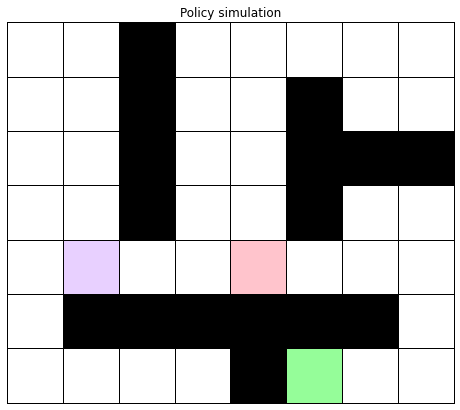

In [19]:
if __name__ == "__main__":
    # Description of the maze as a numpy array
    maze = np.array([
        [0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0, 1, 1, 1],
        [0, 0, 1, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 1, 0],
        [0, 0, 0, 0, 1, 2, 0, 0]])
    # With the convention 0 = empty cell, 1 = obstacle, 2 = exit of the Maze
    
    env = Maze(maze) # Create an environment maze
    horizon = 20       # TODO: Finite horizon
    gamma = 29/30
    epsilon = 0.0000001 #10^-4

    # Solve the MDP problem with dynamic programming
    V, policy = value_iteration(env, gamma, epsilon)

    # Simulate the shortest path starting from position A
    method = 'ValIter'
    start  = ((0,0), (6,5)) # Initial state
    path = env.simulate(start, policy, method)[0]

    animate_solution(maze, path)

In [21]:
path = env.simulate(start, policy, method)[0]

path

[((0, 0), (6, 5)),
 ((0, 1), (6, 4)),
 ((1, 1), (5, 4)),
 ((2, 1), (4, 4)),
 ((3, 1), (4, 5)),
 ((4, 1), (3, 5)),
 ((4, 2), (2, 5)),
 ((4, 3), (1, 5)),
 ((4, 4), (0, 5)),
 ((4, 5), (0, 4)),
 ((4, 6), (0, 3)),
 ((4, 7), (1, 3)),
 ((5, 7), (1, 4)),
 ((6, 7), (0, 4)),
 ((6, 6), (0, 3)),
 'Win',
 'Win']

In [23]:
n_alive = 0
n_horizon_more_15 = 0
for sim in range(10000):
    # Simulate the shortest path starting from position A
    method = 'ValIter'
    start  = ((0,0), (6,5)) # Initial state
    sim = env.simulate(start, policy, method)
    if sim[1]>=15:
        n_horizon_more_15+=1
    else:
        #animate_solution(maze, path)
        continue

    if sim[0][-1] == 'Win':
        n_alive+=1

print(n_alive)
print(n_horizon_more_15)

6248
6248


In [7]:
unique_actions = set()  # Use this instead of naming it 'set'

# Iterate over each state in the environment
for state in range(env.n_states):
    # Check if the condition on env.states is satisfied
    if env.states[state][0][0] == 0 and env.states[state][0][1] == 0:
        # Add the corresponding policy action to the set
        unique_actions.add(policy[state])

print(unique_actions)

{0, 2, 4}


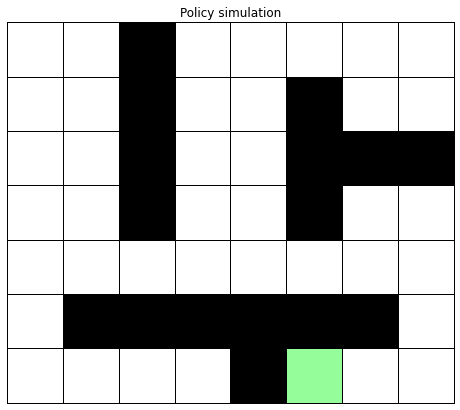

In [31]:
animate_solution(maze, path)

In [32]:
path

[((0, 0), (6, 5)),
 ((0, 1), (5, 5)),
 ((1, 1), (6, 5)),
 ((2, 1), (5, 5)),
 ((3, 1), (5, 6)),
 ((4, 1), (5, 5)),
 ((4, 2), (6, 5)),
 ((4, 3), (5, 5)),
 ((4, 4), (4, 5)),
 ((4, 5), (4, 4)),
 ((4, 6), (4, 3)),
 ((4, 7), (3, 3)),
 ((5, 7), (4, 3)),
 ((6, 7), (3, 3)),
 ((6, 6), (4, 3)),
 'Win',
 'Win']

In [82]:
policy[2158]

1

In [50]:
path = env.simulate(start, policy, method)[0]

path

[((0, 0), (6, 5)),
 ((0, 1), (6, 4)),
 ((1, 1), (6, 3)),
 ((2, 1), (6, 4)),
 ((3, 1), (6, 3)),
 ((4, 1), (6, 4)),
 ((4, 2), (6, 3)),
 ((4, 3), (6, 2)),
 ((4, 4), (6, 3)),
 ((4, 5), (6, 4)),
 ((4, 6), (6, 5)),
 ((4, 7), (5, 5)),
 ((5, 7), (4, 5)),
 ((6, 7), (3, 5)),
 ((6, 6), (3, 6)),
 ((6, 6), (3, 7)),
 'Win',
 'Win']

In [51]:
env.map[(6, 6), (3, 6)]

2158

In [81]:
policy[2158]

1

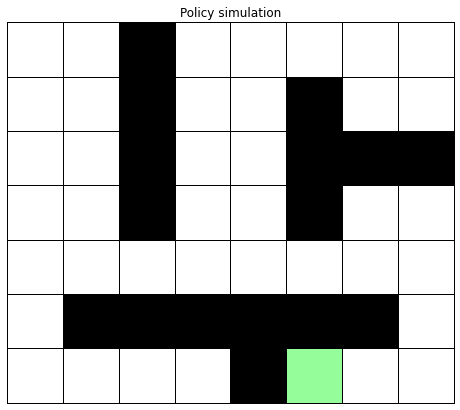

In [53]:
animate_solution(maze, path)

[((0, 0), (6, 5)),
 ((0, 1), (5, 5)),
 ((1, 1), (4, 5)),
 ((2, 1), (5, 5)),
 ((3, 1), (5, 6)),
 ((4, 1), (4, 6)),
 ((4, 2), (3, 6)),
 ((4, 3), (3, 7)),
 ((4, 4), (3, 6)),
 ((4, 5), (3, 7)),
 ((4, 6), (3, 6)),
 ((4, 7), (2, 6)),
 ((5, 7), (2, 5)),
 ((6, 7), (2, 6)),
 ((6, 6), (1, 6)),
 ((6, 6), (1, 7)),
 ((6, 6), (0, 7)),
 'Win',
 'Win']

In [11]:
path = env.simulate(start, policy, method)

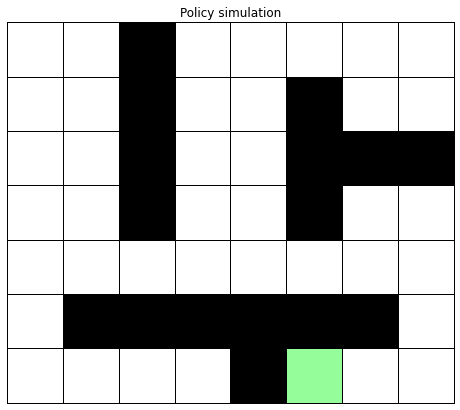

In [15]:
animate_solution(maze, path[0])

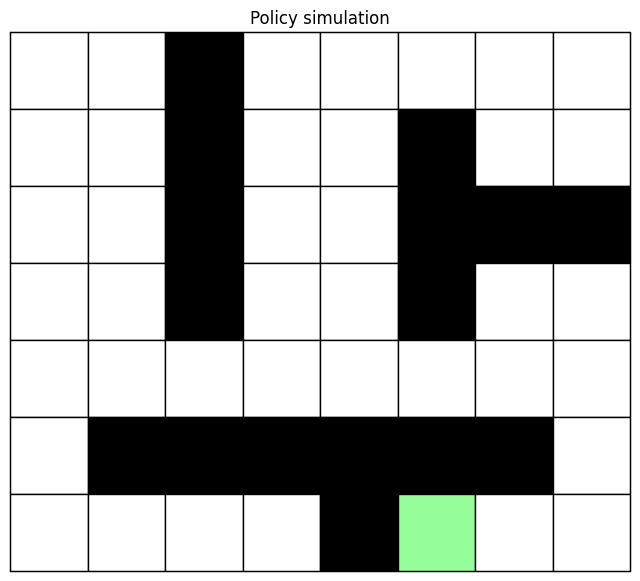

In [21]:
env = Maze(maze) # Create an environment maze

# Simulate the shortest path starting from position A
method = 'ValIter'
start  = ((0,0), (6,5)) # Initial state
path = env.simulate(start, policy, method)[0]

animate_solution(maze, path)

In [22]:
path

[((0, 0), (6, 5)),
 ((0, 1), (6, 4)),
 ((1, 1), (5, 4)),
 ((2, 1), (4, 4)),
 ((3, 1), (3, 4)),
 ((4, 1), (2, 4)),
 ((4, 2), (2, 5)),
 ((4, 3), (3, 5)),
 ((4, 4), (4, 5)),
 ((4, 5), (4, 4)),
 ((4, 6), (4, 3)),
 ((4, 7), (4, 4)),
 ((5, 7), (4, 3)),
 ((6, 7), (4, 4)),
 ((6, 6), (5, 4)),
 ((6, 6), (5, 5)),
 ((6, 6), (6, 5)),
 'Win',
 'Win']